High Density Regions can be used to estimated the cross sections across multi-dimensional space that has the highest concentrations of data points. It can also compute the average value of an aggregate statistic with respect to a target variable.

In [1]:
import kernelml
import numpy as np
import pandas as pd


import re
df = pd.read_csv('data/Pokemon.csv').fillna('')
types = np.concatenate([df['Type 1'].unique(),df['Type 2'].unique()])
df['Type']=df[['Type 1','Type 2']].apply(lambda x: str(x[0])+str(x[1]),axis=1)
df.drop(['Type 1','Type 2'],axis=1,inplace=True)
df['Mega'] = df.Name.apply(lambda x: len(re.findall('Mega',x))>0).astype(np.int)
df['Grass'] = df.Type.apply(lambda x: len(re.findall('Grass',x))>0).astype(np.int)

features = np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def','Speed'])

y = df[features].fillna(0).values.astype(np.float)

model = kernelml.region_estimator.HighDensityRegions(number_of_clusters=12)

#agg_func: 'mean', 'variance', 'max', 'false-positive-cost', 'false-negative-cost', 'count'
model.optimize(y,y, bins_per_dimension=61, number_of_random_simulations=1200, 
               number_of_realizations=10, smoothing_parameter=3.0,
                 agg_func='count')



realization 0 loss 209.25596326824976 time 6.828362941741943
realization 1 loss 140.33249070378807 time 7.490606784820557
realization 2 loss 111.57890968208201 time 7.443401098251343
realization 3 loss 80.85830539391465 time 7.563106060028076
realization 4 loss 69.59823020218008 time 7.487354040145874
realization 5 loss 59.577110678230426 time 7.528113842010498
realization 6 loss 53.94861941919494 time 7.533008813858032
realization 7 loss 48.47790182444933 time 7.629344940185547
realization 8 loss 45.59759396533666 time 7.687708139419556
realization 9 loss 44.536004389478805 time 7.852521181106567


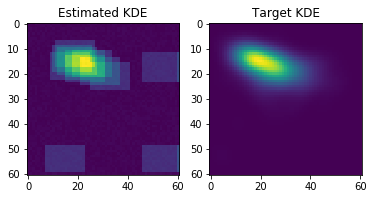

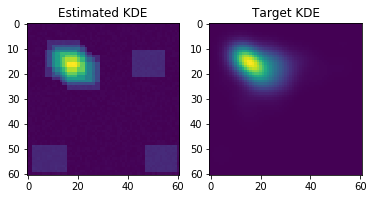

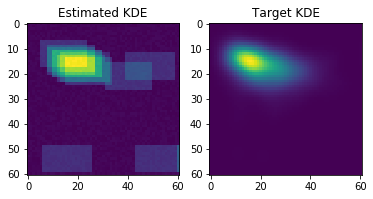

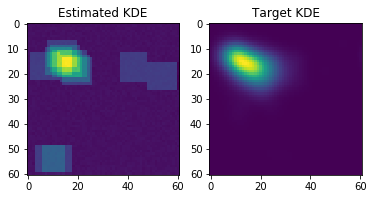

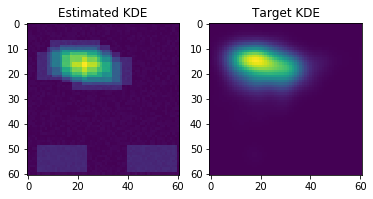

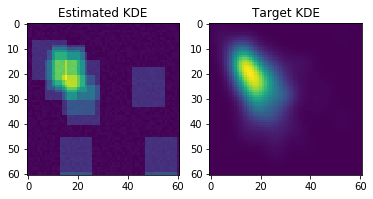

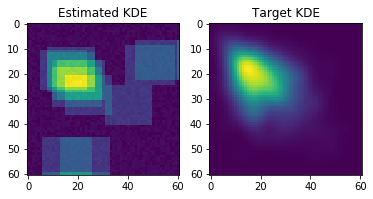

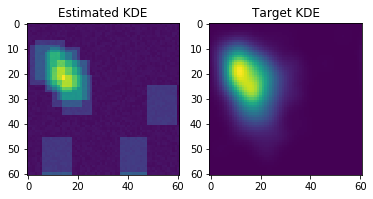

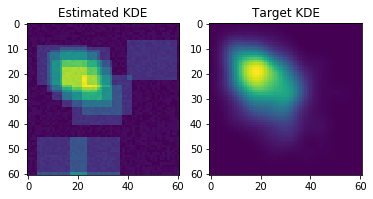

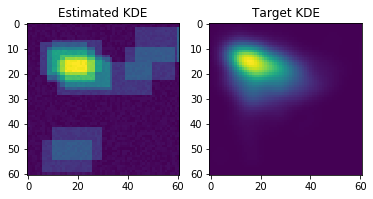

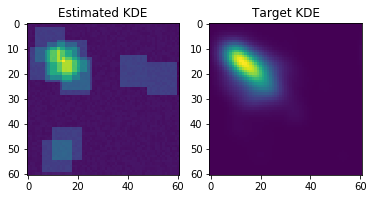

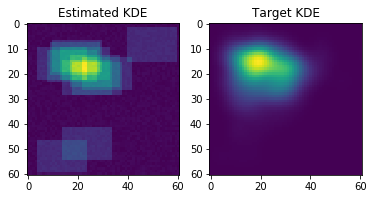

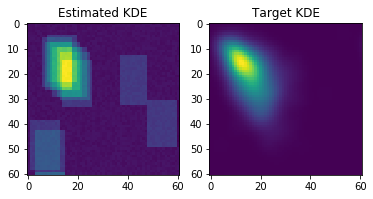

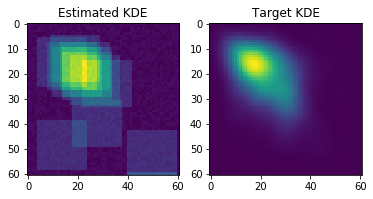

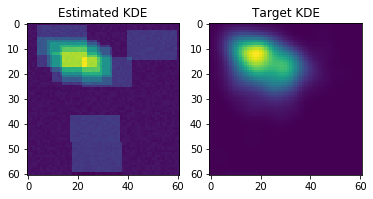

In [4]:
#inspect distributions
import matplotlib.pyplot as plt
count=0
for i,j in model.dim_combos:
    
    plt.subplot(1,2,1)
    plt.imshow(model.kde_estimate[count])
    plt.title('Estimated KDE')

#     plt.show()
    plt.subplot(1,2,2)
    plt.imshow(model.kde_target[count])
    plt.title('Target KDE')
    plt.show()
    count+=1

In [19]:
#choose pad value and prune clusters
pad=1.25
model.prune_clusters(y,pad=1.25,limit=0)

In [20]:
#get assignments
model.get_assignments(y,pad=1.25)

array([[False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ..., False,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False]])

In [21]:
assignments = model.get_assignments(y,pad=1.25)
#compute distances: 'chebyshev','euclidian','mae'
distances = model.get_distances(y,pad=1.25,distance='chebyshev')

In [22]:
#number of assignements per cluster
np.sum(assignments,axis=0)

array([ 10, 521, 524, 502, 295, 587, 636])

In [23]:
#how many data points are in all clusters
np.sum(np.sum(assignments,axis=1)==8)

0

In [24]:
#how many data points not in clusters
np.sum(np.sum(assignments,axis=1)==0)

94

In [25]:
#cluster centroids and deviations
centroids = model.centroids_
deviations = model.deviations_

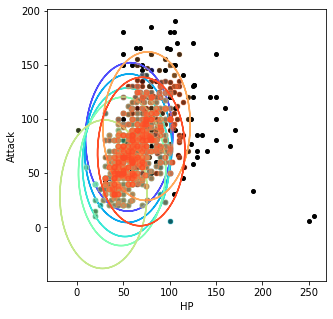

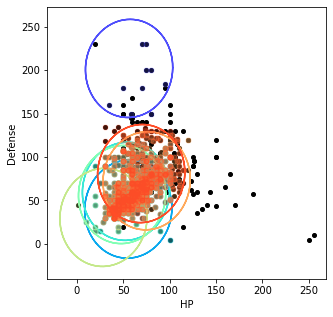

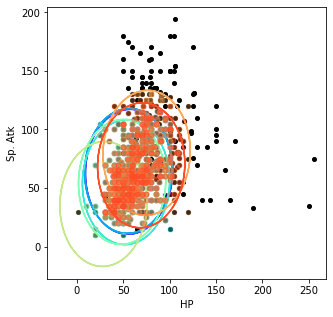

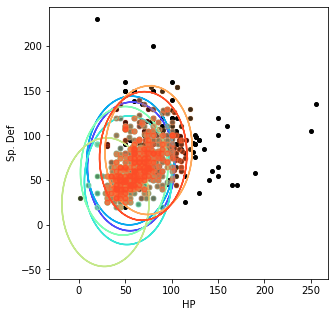

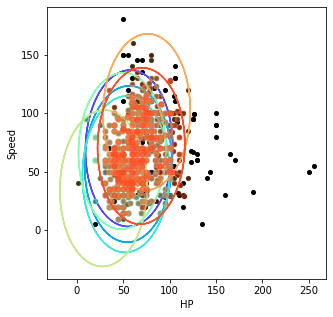

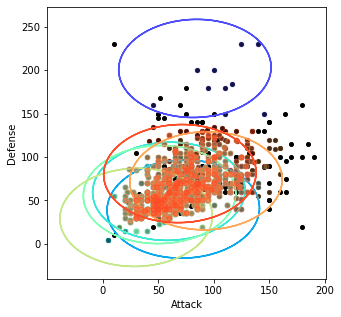

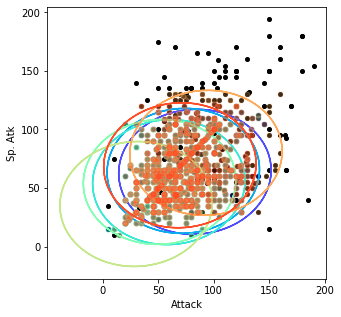

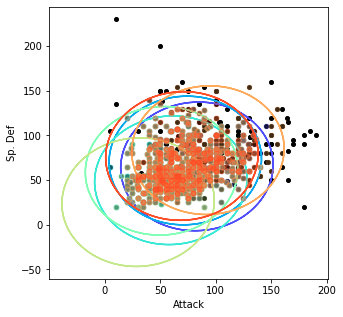

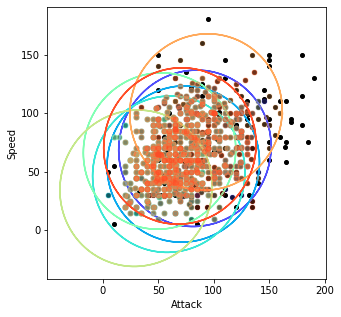

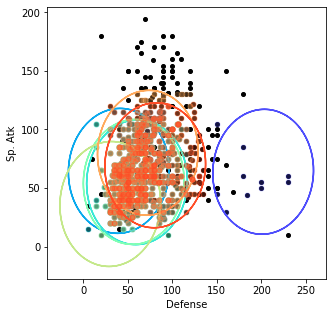

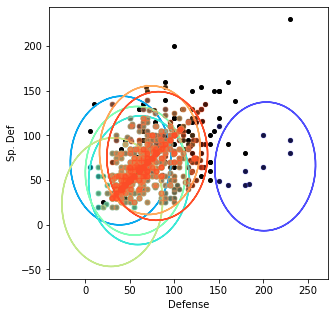

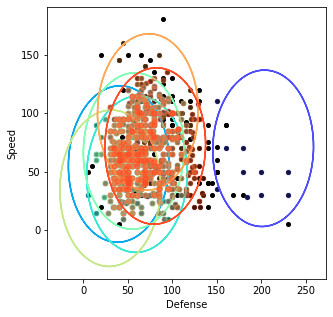

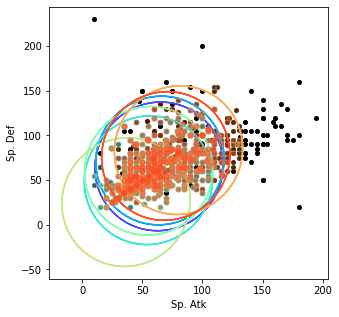

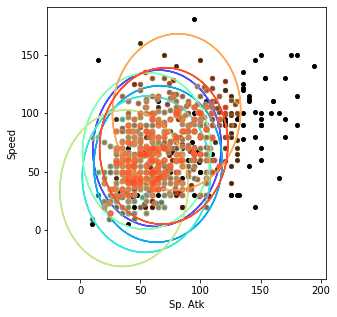

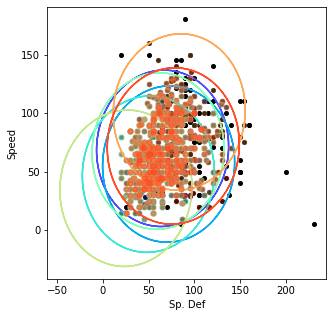

In [26]:
#visualize clusters
count=1
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0.1,0.9, model.num_clusters))
for i,j in model.dim_combos:
    plt.figure(figsize=(5,5))

    plt.plot(y[:,i],y[:,j],'.',color='black', markersize=8)

    for k in range(model.num_clusters):
        
        w1 = centroids[k,i]
        w2 = centroids[k,j]
        
        dev0 = deviations[i,0]
        dev1 = deviations[j,0]
        
        #covariance matrix
        C = np.array([[(dev0*pad)**2,0.],[0.,(dev1*pad)**2]])

        eVa, eVe = np.linalg.eig(C)
        R, S = eVe, np.diag(np.sqrt(eVa))

        #create circle (points)
        z = np.arange(0,2*np.pi+np.pi/128,np.pi/128)
        points = np.array([[np.cos(z[i]),np.sin(z[i+1])] for i in range(z.shape[0]-1)])
        points = np.concatenate([points,points[1:]])
        
        T = (S).dot(R.T)
        points = points.dot(T)
        
        points[:,0] = points[:,0]+w1
        points[:,1] = points[:,1]+w2
        plt.plot(points[:,0],points[:,1],color=colors[k])
        
        submask = assignments[:,k]==1
        plt.plot(y[submask,i],y[submask,j],'.',color=colors[k], markersize=10,alpha=0.25)
        plt.xlabel(features[i])
        plt.ylabel(features[j])
#     submask = np.any,axis=1)


    count+=1
    plt.show()